In [91]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import make_moons, make_circles
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

In [92]:
def generate_data(dataset="moons", n_samples=500, noise=0.1):
    if dataset == "moons":
        X, y = make_moons(n_samples=n_samples, noise=noise)
    elif dataset == "donuts":
        X, y = make_circles(n_samples=n_samples, noise=noise, factor=0.5)
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.long)
    return X, y

In [93]:
class SmallMLP(nn.Module):
    def __init__(self, in_dim=2, hidden=3, out_dim=2):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(in_dim, hidden),
            nn.Linear(hidden, hidden),
            nn.Linear(hidden, out_dim)
        ])

    def forward(self, x):
        activations = []
        for layer in self.layers[:-1]:
            x = torch.tanh(layer(x))
            activations.append(x.detach())
        x = self.layers[-1](x)
        activations.append(x.detach())
        return x, activations


In [94]:
class DeepMLP(nn.Module):
    def __init__(self, in_dim=2, hidden=6, out_dim=2, depth=6):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(in_dim, hidden)])
        for _ in range(depth - 2):
            self.layers.append(nn.Linear(hidden, hidden))
        self.layers.append(nn.Linear(hidden, out_dim))

    def forward(self, x):
        activations = []
        for layer in self.layers[:-1]:
            x = torch.tanh(layer(x))
            activations.append(x.detach())
        x = self.layers[-1](x)
        activations.append(x.detach())
        return x, activations

In [95]:
def train_model(model, X, y, epochs=1000, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        out, _ = model(X)
        loss = F.cross_entropy(out, y)
        loss.backward()
        optimizer.step()
    return model

In [96]:
def plot_activations(activations, y, title_prefix=""):
    num_layers = len(activations)
    fig, axes = plt.subplots(1, num_layers, figsize=(4 * num_layers, 3))
    if num_layers == 1:
        axes = [axes]
    for i, act in enumerate(activations):
        act_np = act.numpy()
        if act_np.shape[1] > 2:
            from sklearn.decomposition import PCA
            act_np = PCA(n_components=2).fit_transform(act_np)
        axes[i].scatter(act_np[:, 0], act_np[:, 1], c=y, cmap="coolwarm", s=10)
        axes[i].set_title(f"{title_prefix} Layer {i + 1}")
    plt.show()

In [97]:
X, y = generate_data(dataset="donuts")


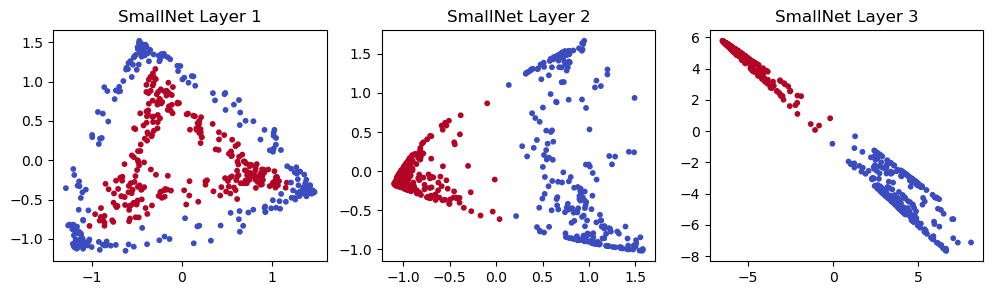

In [98]:
small_net = SmallMLP()
small_net = train_model(small_net, X, y)
_, small_acts = small_net(X)
plot_activations(small_acts, y, title_prefix="SmallNet")

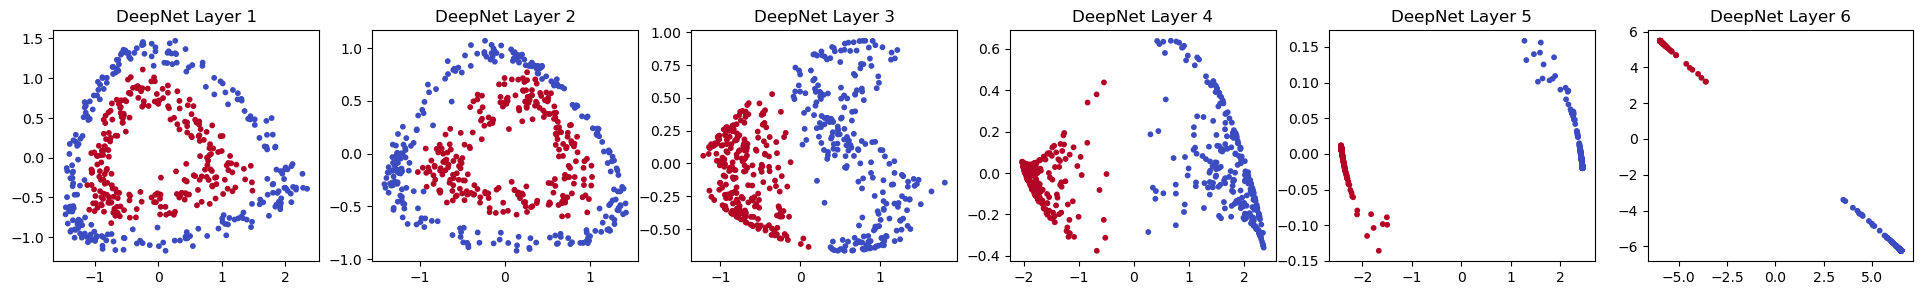

In [99]:
deep_net = DeepMLP()
deep_net = train_model(deep_net, X, y)
_, deep_acts = deep_net(X)
plot_activations(deep_acts, y, title_prefix="DeepNet")

In [100]:
def compute_layer_movements(activations, n_components=2):
    """
    Compute PCA-based movement magnitudes per layer.

    Args:
        activations (list of torch.Tensor): Activations for each layer (batch_size, feature_dim).
        n_components (int): Number of PCA components to keep.

    Returns:
        movements (list of float): PCA movement magnitude per layer.
        cumulative (list of np.ndarray): Cumulative trajectory per layer in PCA space.
    """
    movements = []
    cumulative = []

    for i, a in enumerate(activations):
        a_np = a.detach().cpu().numpy()  # ensure numpy conversion
        if a_np.ndim > 2:  # flatten if conv output
            a_np = a_np.reshape(a_np.shape[0], -1)

        # Run PCA per layer
        n_comp = min(n_components, a_np.shape[1])  # cannot exceed feature dim
        pca = PCA(n_components=n_comp)
        reduced = pca.fit_transform(a_np)

        # Movement = mean L2 norm in PCA space
        diffs = np.diff(reduced, axis=0)
        movement = np.mean(np.linalg.norm(diffs, axis=1))
        movements.append(movement)

        # Cumulative trajectory
        traj = np.cumsum(np.linalg.norm(diffs, axis=1))
        cumulative.append(traj)

    return movements, cumulative

In [101]:
small_movements, small_cum = compute_layer_movements(small_acts)
deep_movements, deep_cum = compute_layer_movements(deep_acts)
print("SmallNet movements per layer:", small_movements)
print("SmallNet cumulative movement:", small_cum)
print("DeepNet movements per layer:", deep_movements)
print("DeepNet cumulative movement:", deep_cum)

SmallNet movements per layer: [1.3401902, 1.3975233, 7.523735]
SmallNet cumulative movement: [array([  1.5296273,   1.7808125,   3.2038488,   4.380242 ,   5.9312243,
         7.365704 ,   8.027605 ,   9.087573 ,  10.187629 ,  10.899624 ,
        13.048967 ,  15.459863 ,  16.824244 ,  17.077772 ,  19.25926  ,
        20.699408 ,  22.159966 ,  23.936047 ,  24.35715  ,  25.086746 ,
        25.752548 ,  26.767355 ,  28.302395 ,  30.203411 ,  31.728556 ,
        33.594093 ,  34.73693  ,  35.915867 ,  36.386246 ,  37.918266 ,
        38.67679  ,  39.290836 ,  39.74308  ,  41.182716 ,  43.06801  ,
        44.289326 ,  44.86581  ,  46.98743  ,  49.116177 ,  50.798367 ,
        51.910267 ,  52.89468  ,  53.937603 ,  54.31195  ,  55.547485 ,
        55.65341  ,  55.965393 ,  57.783863 ,  60.26324  ,  62.07247  ,
        62.3811   ,  63.44491  ,  63.984    ,  65.31223  ,  66.15981  ,
        67.7161   ,  69.30682  ,  70.14966  ,  70.984924 ,  73.22702  ,
        74.00272  ,  75.541855 ,  76.3621 

In [102]:
def plot_movements_and_cumulative(movements_small, cumulative_small,
                                  movements_deep, cumulative_deep,
                                  small_label="SmallNet", deep_label="DeepNet"):
    """
    Plot per-layer PCA movements and cumulative trajectories.
    """

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # --- Left: per-layer movement magnitude ---
    axes[0].plot(range(len(movements_small)), movements_small, marker='o', label=small_label)
    axes[0].plot(range(len(movements_deep)), movements_deep, marker='o', label=deep_label)
    axes[0].set_title("Per-Layer PCA Movement")
    axes[0].set_xlabel("Layer")
    axes[0].set_ylabel("Movement magnitude")
    axes[0].legend()
    axes[0].grid(True, linestyle="--", alpha=0.6)

    # --- Right: cumulative trajectories ---
    for i, traj in enumerate(cumulative_small):
        axes[1].plot(traj, label=f"{small_label} Layer {i}")
    for i, traj in enumerate(cumulative_deep):
        axes[1].plot(traj, label=f"{deep_label} Layer {i}", linestyle="--")

    axes[1].set_title("Cumulative Trajectories per Layer")
    axes[1].set_xlabel("Step")
    axes[1].set_ylabel("Cumulative distance")
    axes[1].legend(fontsize=8, ncol=2)
    axes[1].grid(True, linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.show()

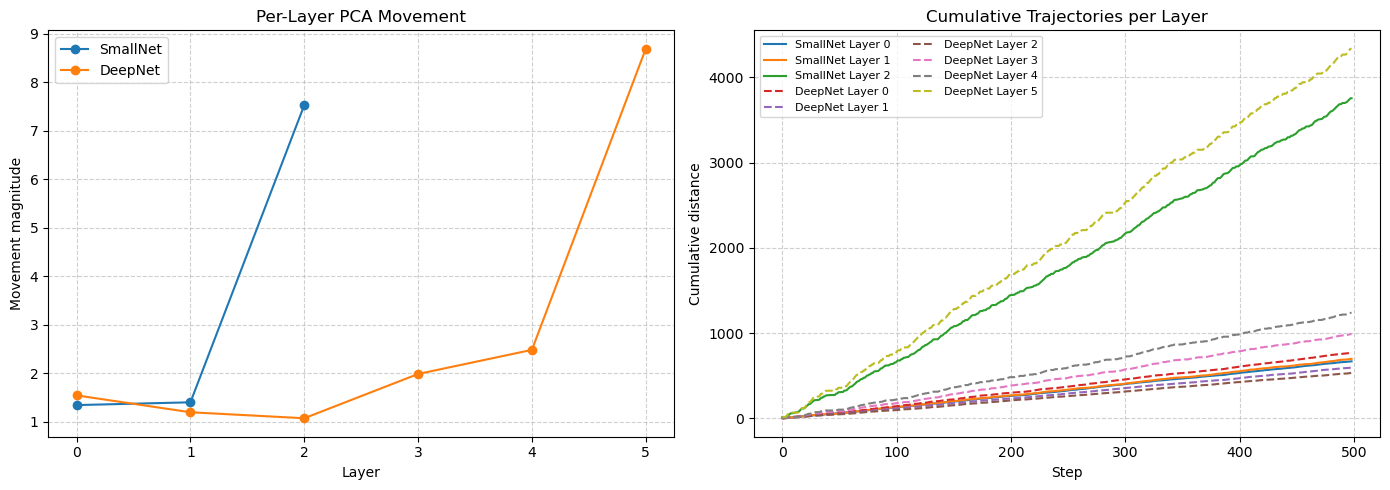

In [103]:
plot_movements_and_cumulative(small_movements, small_cum, deep_movements, deep_cum)

In [3]:
! export PATH=/Library/TeX/texbin/xelatex:$PATH